# Training with 2D slices from volumes

This tutorial shows how to train a network with 2D samples from 3D inputs.

It mainly demonstrates 2d slice dataset using `monai.data.PatchIterd` and `monai.data.GridPatchDataset`.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/2d_slices_from_3d.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm, nibabel]"
%matplotlib inline

## Setup imports

In [ ]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import tempfile
from glob import glob
import shutil

import matplotlib.pyplot as plt
import monai
import nibabel as nib
import numpy as np
import torch
from monai.data import DataLoader, create_test_image_3d
from monai.inferers import SliceInferer
from monai.metrics import DiceMetric
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    RandRotate90d,
    Resized,
    ScaleIntensityd,
    SqueezeDimd,
)
from monai.visualize import matshow3d

monai.config.print_config()
monai.utils.set_determinism(0)

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

## Create a dataset

The example volumes are created with different spatial shapes for demo purposes


In [4]:
print(f"generating synthetic data to {root_dir} (this may take a while)")
for i in range(40):
    # make the input volumes different spatial shapes for demo purposes
    H, W, D = 30 + i, 40 + i, 50 + i
    im, seg = create_test_image_3d(
        H, W, D, num_seg_classes=1, channel_dim=-1, rad_max=10
    )

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"img{i:d}.nii.gz"))
    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"seg{i:d}.nii.gz"))

images = sorted(glob(os.path.join(root_dir, "img*.nii.gz")))
segs = sorted(glob(os.path.join(root_dir, "seg*.nii.gz")))

generating synthetic data to /Users/wenqili/Documents/monai_data (this may take a while)


In [5]:
train_files = [{"img": img, "seg": seg} for img, seg in zip(images[:35], segs[:35])]
val_files = [{"img": img, "seg": seg} for img, seg in zip(images[-3:], segs[-3:])]

## Volume-level preprocessing

In [6]:
# volume-level transforms for both image and segmentation
train_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys="img"),
        RandRotate90d(keys=["img", "seg"], prob=0.5, spatial_axes=[0, 2]),
        EnsureTyped(keys=["img", "seg"]),
    ]
)
# 3D dataset with preprocessing transforms
volume_ds = monai.data.CacheDataset(data=train_files, transform=train_transforms)
# use batch_size=1 to check the volumes because the input volumes have different shapes
check_loader = DataLoader(volume_ds, batch_size=1)
check_data = monai.utils.misc.first(check_loader)
print("first volume's shape: ", check_data["img"].shape, check_data["seg"].shape)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 109.45it/s]

first volume's shape:  torch.Size([1, 1, 50, 30, 40]) torch.Size([1, 1, 50, 30, 40])


## volume to patch processing

- define the 2d slice dataset using `monai.data.PatchIterd` and `monai.data.GridPatchDataset`
- patch-level preprocessing, resize the sampled slices to a consistent size so that we can batch
the last spatial dim is always 1, so we squeeze dim.

In [7]:
patch_func = monai.data.PatchIterd(
    keys=["img", "seg"],
    patch_size=(None, None, 1),  # dynamic first two dimensions
    start_pos=(0, 0, 0)
)
patch_transform = Compose(
    [
        SqueezeDimd(keys=["img", "seg"], dim=-1),  # squeeze the last dim
        Resized(keys=["img", "seg"], spatial_size=[48, 48]),
        # to use crop/pad instead of reszie:
        # ResizeWithPadOrCropd(keys=["img", "seg"], spatial_size=[48, 48], mode="replicate"),
    ]
)
patch_ds = monai.data.GridPatchDataset(
    data=volume_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False)
train_loader = DataLoader(
    patch_ds,
    batch_size=5,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)
check_data = monai.utils.misc.first(train_loader)

## Define 2D network and losses

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 5e-3)

## The training loop

In [9]:
epoch_loss_values = []
num_epochs = 5
for epoch in range(num_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()
    epoch_loss, step = 0, 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["img"].to(device), batch_data["seg"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 200 == 0:
            print(f"{step}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
print("train completed")

----------
epoch 1/5
200, train_loss: 1.0000
400, train_loss: 0.0747
epoch 1 average loss: 0.4299
----------
epoch 2/5
200, train_loss: 0.0490
400, train_loss: 1.0000
epoch 2 average loss: 0.2845
----------
epoch 3/5
200, train_loss: 0.9365
400, train_loss: 0.4271
epoch 3 average loss: 0.2817
----------
epoch 4/5
200, train_loss: 0.0836
400, train_loss: 0.1104
epoch 4 average loss: 0.2690
----------
epoch 5/5
200, train_loss: 0.0659
400, train_loss: 0.1202
epoch 5 average loss: 0.2769
train completed


## SliceInferer

Dice:  tensor(0.9861)


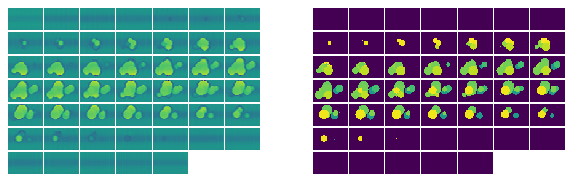

Dice:  tensor(0.9780)


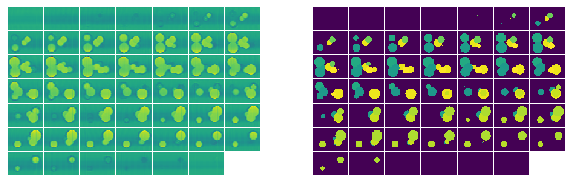

Dice:  tensor(0.9807)


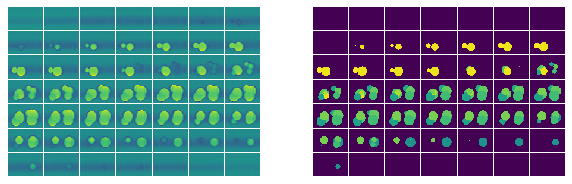

Avg Dice: 0.9816081523895264


In [10]:
val_transform = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys="img"),
        EnsureTyped(keys=["img", "seg"]),
    ]
)
val_files = [{"img": img, "seg": seg} for img, seg in zip(images[-3:], segs[-3:])]
val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
data_loader = DataLoader(val_ds, num_workers=1, pin_memory=torch.cuda.is_available())
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
model.eval()
with torch.no_grad():
    for val_data in data_loader:
        val_images = val_data["img"].to(device)
        roi_size = (48, 48)
        sw_batch_size = 3
        slice_inferer = SliceInferer(
            roi_size=roi_size,
            sw_batch_size=sw_batch_size,
            spatial_dim=1,  # Spatial dim to slice along is defined here
            device=torch.device("cpu"),
            padding_mode="replicate",
        )
        val_output = slice_inferer(val_images, model)
        dice_metric(y_pred=val_output > 0.5, y=val_data["seg"])
        print("Dice: ", dice_metric.get_buffer()[-1][0])
        fig = plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        matshow3d(val_output[0], fig=plt.gca())
        plt.subplot(1, 2, 2)
        matshow3d(val_images[0], fig=plt.gca())
        plt.show()
    print(f"Avg Dice: {dice_metric.aggregate().item()}")

## Cleanup data directory

Remove directory if a temporary was used.

In [11]:
if directory is None:
    shutil.rmtree(root_dir)